In [45]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import tqdm
import time
import yaml
import h5py
import scipy
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime
import torch.fft
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple

from scipy.sparse import csr_matrix
from colour import Color

import multiprocessing as mp
#mp.set_start_method('spawn')

from functools import partial

from hagelslag.evaluation.ProbabilityMetrics import *
from hagelslag.evaluation.MetricPlotter import *

In [17]:
%matplotlib inline

In [18]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [19]:
# # Dice similarity function

# def dice_coef(y_true, y_pred):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
#     intersection = torch.sum(y_true_f * y_pred_f)
    
#     if intersection == 0.0:
#         return 1.0
    
#     smooth = 0.0001
#     result = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
#     return result.item()

# def dice_coef2(y_true, y_pred):
#     y_true_f = y_true.ravel()
#     y_pred_f = y_pred.ravel()
#     union = np.sum(y_true_f) + np.sum(y_pred_f)
#     if union == 0: 
#         return 1.0
#     smooth = 0.0001
#     intersection = np.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (smooth + union)

In [20]:
def save_sparse_csr(filename, array):
    # note that .npz extension is added automatically
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [21]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(2, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [22]:
class InferencePropagator:
    
    def __init__(self, 
                 data_path,
                 n_bins = 1000, 
                 tile_size = 512, 
                 step_size = 128, 
                 marker_size = 10, 
                 model = None,
                 device = "cuda"):
        
        self.h_ds = xr.open_dataset(data_path)
        self.n_bins = n_bins
        self.z_bins = np.linspace(self.h_ds.attrs['zMin'],self.h_ds.attrs['zMax'], n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5*np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        self.marker_size = marker_size # UNET gaussian marker width (standard deviation) in um
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx']) # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny']) # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda'] # wavelength
        self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
        self.zMax = self.h_ds.attrs['zMax'] 
        self.image_norm = 255.0

        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy
        
        self.tile_x_bins = np.arange(-self.Nx//2,self.Nx//2,self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,self.Ny//2,self.step_size)*self.dy*1e6
        
        self.fx = None
        self.fy = None
        self.model = model
        self.model.eval()
        
        self.create_mapping()

    
    def compute_f(self):
        self.fx = torch.fft.fftfreq(self.Nx,self.dx,device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(self.Ny,self.dy,device=self.device).unsqueeze(0).unsqueeze(1)
        
    
    def torch_holo_set(self, 
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """
        if self.fx is None:
            self.compute_f()
        
        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam*torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout
    

    def create_mapping(self):
        self.idx2slice = {}
        for row_idx in range(self.Nx//self.step_size):

            if row_idx*self.step_size+self.tile_size > self.Nx:
                image_pixel_x = self.Nx-self.tile_size
                row_slice = slice(-self.tile_size,None)
                row_break = True
            else:
                image_pixel_x = row_idx*self.step_size
                row_slice = slice(row_idx*self.step_size,row_idx*self.step_size+self.tile_size)
                row_break = False

            for col_idx in range(self.Ny//self.step_size):

                if col_idx*self.step_size+self.tile_size > self.Ny:
                    image_pixel_y = self.Ny-self.tile_size
                    col_slice = slice(-self.tile_size,None)
                    col_break = True
                else:
                    image_pixel_y = col_idx*self.step_size
                    col_slice = slice(col_idx*self.step_size,col_idx*self.step_size+self.tile_size)
                    col_break = False
                    
                self.idx2slice[row_idx, col_idx] = (row_slice, col_slice) 

                if col_break: 
                    break

            if row_break:
                break
        

    def get_sub_images_labeled(self,
                               image_tnsr, 
                               z_sub_set, 
                               z_counter, 
                               xp, yp, zp, dp, 
                               infocus_mask, 
                               z_part_bin_idx, 
                               batch_size = 32, 
                               thresholds = None, 
                               obs_threshold = None):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """
        
        with torch.no_grad():
    
            # build the torch tensor for reconstruction
            z_plane = torch.tensor(z_sub_set*1e-6,device=self.device).unsqueeze(-1).unsqueeze(-1)

            # reconstruct the selected planes
            E_out = self.torch_holo_set(image_tnsr,z_plane)

            image = torch.abs(E_out).unsqueeze(1)
            phase = torch.angle(E_out).unsqueeze(1)
            stacked_image = torch.cat([
                torch.abs(E_out).unsqueeze(1), torch.angle(E_out).unsqueeze(1)], 1)

            size = (E_out.shape[1], E_out.shape[2])
            true_label = torch.zeros(size).to(device)
            pred_label = torch.zeros(size).to(device)
            pred_proba = torch.zeros(size).to(device)
            counter = torch.zeros(size).to(device)

            results_dict = defaultdict(list)

            for z_idx in range(E_out.shape[0]):
                
                chunked = np.array_split(
                    list(self.idx2slice.items()),
                    int(np.ceil(len(self.idx2slice) / batch_size))
                )
                
                input_x = stacked_image[z_idx, :].float()
                true_y = infocus_mask[:, :, z_idx+z_counter]
                 
                worker = partial(
                    self.collate, 
                    image = input_x, 
                    label = true_y
                )
                                    
                for chunk in chunked:
                    
                    slices, x, true_labels = worker(chunk)
                    #x = x.to(device)
                    true_labels = true_labels.to(device)
                    pred_logits = self.model(x)
                    
                    pred_probs, pred_labels = torch.max(pred_logits, 1)
                    pred_probs = pred_probs.exp()
                    pred_labels = pred_labels.squeeze(-1)
                    
                    pred_cond = pred_labels == 0
                    pred_probs = torch.where(pred_cond, 1.0 - pred_probs, pred_probs)

                    acc = true_labels == pred_labels
                    results_dict["acc"] += acc

                    for k, ((row_idx, col_idx), (row_slice, col_slice)) in enumerate(slices):
                        counter[row_slice, col_slice] += 1
                        true_label[row_slice, col_slice] += true_labels[k]
                        pred_label[row_slice, col_slice] += pred_labels[k]
                        pred_proba[row_slice, col_slice] += pred_probs[k]
                        
                        
            pred_label = pred_label / counter
            pred_proba = pred_proba / counter
            true_label = true_label / counter        
            ave_acc = [x.detach().cpu().numpy()[0] for x in results_dict["acc"]]

            pred_label = pred_label == 1.0
            true_label = true_label == 1.0
            
            pred_label = pred_label.cpu().numpy()
            pred_proba = pred_proba.cpu().numpy()
            true_label = true_label.cpu().numpy()
            
            roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
            roc.update(pred_proba.ravel(), true_label.ravel())
            
            return_dict = {
                "pred_label": pred_label,
                "pred_proba": pred_proba,
                "true_label": true_label,
                #"counter": counter,
                "acc": np.mean(ave_acc),
                "z_plane": z_sub_set[z_idx],
                "roc": roc
            }
                    
        return return_dict
    
    def collate(self, batch, image = None, label = None):
        x, y = zip(*[
            (image[:, row_slice, col_slice], 
            torch.LongTensor([int(label[row_idx, col_idx])]))
            for ((row_idx, col_idx), (row_slice, col_slice)) in batch
        ])
        x = torch.stack(x)
        y = torch.stack(y)
        return batch, x, y

            
    def get_next_z_planes_labeled(self, 
                                  h_idx, 
                                  z_planes_lst, 
                                  batch_size = 32,
                                  thresholds = np.arange(0.0, 1.1, 0.1),
                                  obs_threshold = 1.0):
        """
        Generator that returns reconstructed z patches
        input_image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """

        # locate particle information corresponding to this hologram
        particle_idx = np.where(self.h_ds['hid'].values==h_idx+1)

        x_part = self.h_ds['x'].values[particle_idx]
        y_part = self.h_ds['y'].values[particle_idx]
        z_part = self.h_ds['z'].values[particle_idx]
        d_part = self.h_ds['d'].values[particle_idx]  # not used but here it is

        # create a 3D histogram 
        in_data = np.stack((x_part, y_part, z_part)).T
        h_part = np.histogramdd(in_data,bins=[self.tile_x_bins,self.tile_y_bins,self.z_bins])[0]
        z_part_bin_idx = np.digitize(z_part, self.z_bins)-1 # specify the z bin locations of the particles

        # smoothing kernel accounts for overlapping subimages when the 
        # subimage is larger than the stride
        if self.step_size < self.tile_size:
            overlap_kernel = np.ones((
                self.tile_size//self.step_size,self.tile_size//self.step_size
            ))
            for z_idx in range(h_part.shape[-1]):
                b = self.tile_size//self.step_size
                h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[b-1:h_part.shape[0]+b-1,b-1:h_part.shape[1]+b-1]

        input_image = self.h_ds['image'].isel(hologram_number=h_idx).values

        z_counter = 0 # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image, device=self.device).unsqueeze(0)
        for z_sub_set in z_planes_lst:
            yield self.get_sub_images_labeled(
                image_tnsr, 
                z_sub_set, 
                z_counter, 
                x_part, y_part, z_part, d_part, h_part, 
                z_part_bin_idx, 
                batch_size = batch_size,
                thresholds = thresholds, 
                obs_threshold = obs_threshold
            )
            z_counter+=z_sub_set.size
            
    def create_z_plane_lst(self, planes_per_call=1):
        """
        Create a list of z planes according to the requested
        batch size.  This generates the z_planes_lst argument
        needed for gen_next_z_plane()
        """
        z_lst = []
        for z_idx in np.arange(0, self.z_centers.size, planes_per_call):
            z_lst.append(self.z_centers[z_idx:(z_idx+planes_per_call)])
        return z_lst

In [23]:
synthetic_path = "/data/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

n_bins = 1000  # number of bins in histogram
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

batch_size = 32

There are 11174402 total model parameters


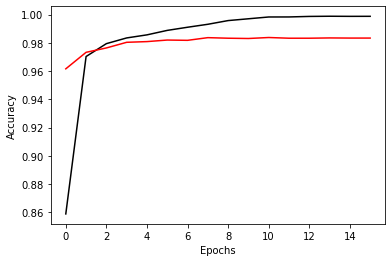

In [24]:
# Load a model

model_loc = "/data/schreck/holodec/reader/resnet18"

f = pd.read_csv(f"{model_loc}/training_log_resnet.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fcl_layers = []
dropout = 0.2
output_size = 2
resnet_model = 18
pretrained = True

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)


checkpoint = torch.load(
    f"{model_loc}/best_resnet.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"There are {total_params} total model parameters")

In [25]:
#model.share_memory()

prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    model = model,
    device = device
)

In [26]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

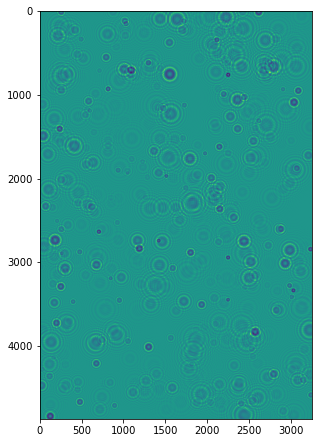

In [27]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (5, 5 * ratio))
plt.imshow(test_image.values)

### Create a list of z-values to propagate to

In [28]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

### Set up thresholds to use for computing ROC

In [29]:
obs_threshold = 1.0
thresholds = 1.0 - np.logspace(-5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
thresholds = thresholds[::-1]

### Initialize the generator

In [30]:
inference_generator = prop.get_next_z_planes_labeled(
    h_idx, 
    z_list, 
    batch_size = batch_size, 
    thresholds = thresholds,
    obs_threshold = obs_threshold
)

### Main loop to call the generator, predict with the model, and aggregate and save the results

##### Skip this line or comment out to avoid re-generating the data, which is slow!

In [40]:
plot = False

model.eval()
with torch.no_grad():

    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list), 
        leave=True
    )

    total_accuracy = []
    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    
    for z_idx, results_dict in jiter:

        # Get stuff from the results dictionary
        pred_label = results_dict["pred_label"]
        pred_prob = results_dict["pred_proba"]
        true_label = results_dict["true_label"]
        acc = results_dict["acc"]
        z_plane = int(results_dict["z_plane"])

        # Save the giant matrices as sparse arrays, as most elements are zero
#         save_sparse_csr(f"resnet50/images/prob_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_prob))

#         pred_label = pred_label == 1.0
#         save_sparse_csr(f"resnet50/images/pred_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_label))

#         true_label = true_label == 1.0
#         save_sparse_csr(f"resnet50/images/true_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))

        # Update any metrics you want printed to screen
        total_accuracy.append(acc)
        roc.merge(results_dict["roc"])
        
        to_print = f"Plane: {z_idx} at z: {z_plane*1e-6} plane_acc: {acc:.6f} holo_acc: {np.mean(total_accuracy):.6f}"
        to_print += f" holo_csi: {roc.max_csi():.6f}"
        jiter.set_description(to_print)
        jiter.update()

        # Option to plot each result per plane
        if plot:
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
            p1 = ax0.imshow(pred_prob, vmin = 0,  vmax = 1)
            ax0.set_title("In-focus confidence")
            fig.colorbar(p1, ax=ax0)

            p2 = ax1.imshow(pred_label, vmin = 0,  vmax = 1)
            ax1.set_title("Predicted particles")
            fig.colorbar(p2, ax=ax1)

            p3 = ax2.imshow(true_label, vmin = 0, vmax = 1)
            ax2.set_title("True particles")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.show()

In [ ]:
### save the ROC object -- DJ I think coded it such that it will save without
### needing to use pickle

### Load the data from saved location

In [25]:
# for z_idx in range(50):

#     pred_prob = load_sparse_csr(f"images/prob_{z_idx}")
#     pred_label = load_sparse_csr(f"images/pred_{z_idx}")
#     true_label = load_sparse_csr(f"images/true_{z_idx}")

#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
#     p1 = ax0.imshow(pred_prob.toarray(), vmin = 0,  vmax = 1)
#     ax0.set_title("In-focus confidence")
#     fig.colorbar(p1, ax=ax0)

#     _pred_label = pred_label == 1.0
#     p2 = ax1.imshow(_pred_label.toarray(), vmin = 0,  vmax = 1)
#     ax1.set_title("Predicted particles")
#     fig.colorbar(p2, ax=ax1)

#     _true_label = true_label == 1.0
#     p3 = ax2.imshow(_true_label.toarray(), vmin = 0, vmax = 1)
#     ax2.set_title("True particles")
#     fig.colorbar(p3, ax=ax2)

#     plt.tight_layout()
#     plt.show()

In [35]:
z_file_indices = sorted([int(x.replace(".npz", "").split("_")[-1]) for x in glob.glob(f"{model_loc}/images/true_*")])

In [39]:
for zidx in z_file_indices:
    shutil.copyfile(f"images/true_{zidx}.npz", f"{model_loc}/images/true_{h_idx}_{zidx}.npz")
    shutil.copyfile(f"images/pred_{zidx}.npz", f"{model_loc}/images/pred_{h_idx}_{zidx}.npz")
    shutil.copyfile(f"images/prob_{zidx}.npz", f"{model_loc}/images/prob_{h_idx}_{zidx}.npz")

In [42]:
red = Color("red")
red_white = list(map(str, red.range_to(Color("white"), 100)))[::-1]
color_range = np.array([x / 100 for x in list(range(100))])

In [60]:
def read_one_plane(z_idx):
    
    colors = []
    x, y, z = [], [], []
    xt, yt, zt = [], [], []

    # Load from sparse 
    pred_prob = load_sparse_csr(f"{model_loc}/images/prob_{h_idx}_{z_idx}")
    pred_label = load_sparse_csr(f"{model_loc}/images/pred_{h_idx}_{z_idx}")
    true_label = load_sparse_csr(f"{model_loc}/images/true_{h_idx}_{z_idx}")
    
    # Convert
    _pred_prob = pred_prob.toarray()
    _pred_label = (pred_label == 1.0).toarray()
    _true_label = (true_label == 1.0).toarray()
    
    # Compute some metrics
    #dice_score = dice_coef(_pred_label, _true_label)
    #dice_score_1 = dice(_pred_label, _true_label, k = 0.0)
    # TP, FP, TN, FN = sklearn.metrics.classification_report()
    
    condition1 = np.where(_pred_label)
    condition2 = np.where(_true_label)
    
    if len(condition1[0]) > 0:
        x += list(condition1[0])
        y += list(condition1[1])
        z += [z_idx for g in range(len(condition1[0]))]
        colors += [red_white[np.abs(color_range - _pred_prob[r][c]).argmin()] for r,c in zip(*condition1)]

    if len(condition2[0]) > 0:
        xt += list(condition2[0])
        yt += list(condition2[1])
        zt += [z_idx for g in range(len(condition2[0]))] 
        
    results = {
        "preds": [x, y, z, colors],
        "truths": [xt, yt, zt],
        "metrics": []
    }
        
    return results

In [61]:
colors = []
X, Y, Z = [], [], []
Xt, Yt, Zt = [], [], []

max_planes = 1000

ncpus = 8

with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(read_one_plane, z_file_indices[:max_planes]), total = max_planes):

        X += results["preds"][0]
        Y += results["preds"][1]
        Z += results["preds"][2]
        colors += results["preds"][3]

        Xt += results["truths"][0]
        Yt += results["truths"][1]
        Zt += results["truths"][2]

100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


(14072.0, 21128.0)

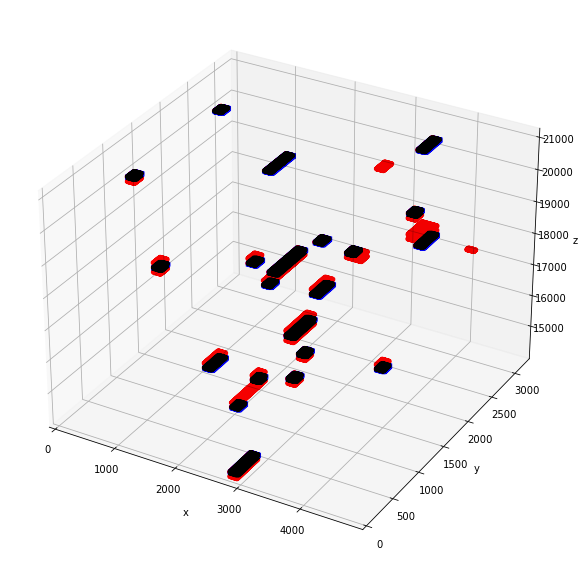

In [65]:
fig = plt.figure(figsize = (10, 14))
ax = plt.axes(projection ="3d")

max_z_view = 100
max_z = z_file_indices[max_z_view-1]
maxn = len([zz for zz in Z if zz <= max_z])

ax.scatter3D(X[:maxn], Y[:maxn], Z[:maxn], c = 'r', alpha = 0.005, zorder = 1, marker = 'o') 
ax.scatter3D(Xt[:maxn], Yt[:maxn], Zt[:maxn], c = 'b', alpha = 0.005, zorder = 1, marker = 's')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, 4872])
ax.set_ylim([0, 3248])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))

hist, binx, biny = np.histogram2d(X, Y, bins = (test_image.shape[0] // step_size, test_image.shape[1] // step_size))
#x = np.linspace(min(X), max(X), hist.shape[0])
#y = np.linspace(min(Y), max(Y), hist.shape[1])
#x, y = np.meshgrid(x, y)
#ax0.contour(x, y, hist, zdir='z', offset=-3.)
ax0.imshow(hist, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("x")
ax0.set_ylabel("y")

histxz, binx, binz = np.histogram2d(X, Z, bins = (test_image.shape[0] // step_size, 1000))
#x = np.linspace(min(X), max(X), hist.shape[0])
#z = np.linspace(min(Z), max(Z), hist.shape[1])
#x, z = np.meshgrid(x, z)
ax1.imshow(histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z")
ax1.set_ylabel("x")

histyz, biny, binz = np.histogram2d(Y, Z, bins = (test_image.shape[1] // step_size, 1000))
#y = np.linspace(min(Y), max(Y), hist.shape[1])
#z = np.linspace(min(Z), max(Z), hist.shape[1])
#z, y = np.meshgrid(z, y)
ax2.imshow(histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax2.set_xlabel("z")
ax2.set_ylabel("y")

plt.tight_layout()

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (15, 10))

histxz, binx, binz = np.histogram2d(X, Z, bins = (test_image.shape[0] // step_size, 1000))
pred_histxz = np.where(histxz > 0.0, 1.0, 0.0)
ax0.imshow(pred_histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_ylabel("x", fontsize = 12)
ax0.set_title("Predicted particles", fontsize = 12)

histxz, binx, binz = np.histogram2d(Xt, Zt, bins = (test_image.shape[0] // step_size, 1000))
true_histxz = np.where(histxz > 0.0, 1.0, 0.0)
ax1.imshow(true_histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z", fontsize = 12)
ax1.set_ylabel("x", fontsize = 12)
ax1.set_title("Real particles", fontsize = 12)

plt.tight_layout()

In [ ]:
accuracy = (pred_histxz == true_histxz).mean()
print(accuracy)

In [ ]:
sklearn.metrics.multilabel_confusion_matrix(true_histxz, pred_histxz).sum(0)

In [ ]:
dice_coef2(true_histxz, pred_histxz)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (15, 10))

histyz, biny, binz = np.histogram2d(Y, Z, bins = (test_image.shape[1] // step_size, 1000))
pred_histyz = np.where(histyz > 0.0, 1.0, 0.0) # make everything black and white
ax0.imshow(pred_histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("z", fontsize = 12)
ax0.set_ylabel("y", fontsize = 12)
ax0.set_title("Predicted particles", fontsize = 12)

histyz, biny, binz = np.histogram2d(Yt, Zt, bins = (test_image.shape[1] // step_size, 1000))
true_histyz = np.where(histyz > 0.0, 1.0, 0.0)
ax1.imshow(true_histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z", fontsize = 12)
ax1.set_ylabel("y", fontsize = 12)
ax1.set_title("Real particles", fontsize = 12)

plt.tight_layout()

### Make a similar plot but on the smaller grid

In [66]:
sx = test_image.shape[0] // step_size
sy = test_image.shape[1] // step_size

In [69]:
def process_one_plane(z_idx):
    
    x, y, z = [], [], []
    xt, yt, zt = [], [], []
    
    true_arr = np.zeros((sx, sy))
    pred_arr = np.zeros((sx, sy))
    
    pred_prob = load_sparse_csr(f"{model_loc}/images/prob_{h_idx}_{z_idx}")
    pred_label = load_sparse_csr(f"{model_loc}/images/pred_{h_idx}_{z_idx}")
    true_label = load_sparse_csr(f"{model_loc}/images/true_{h_idx}_{z_idx}")
    
    for ((row_idx, col_idx), (row_slice, col_slice)) in prop.idx2slice.items():
        
        max_label = np.amax(pred_label[row_slice, col_slice])
        max_probs = np.amax(pred_prob[row_slice, col_slice])
        max_truth = np.amax(true_label[row_slice, col_slice])

        true_arr[row_idx, col_idx] = max_truth
        pred_arr[row_idx, col_idx] = max_label

        if max_label == 1.0:
            x.append(row_idx)
            y.append(col_idx)
            z.append(z_idx)

        if max_truth == 1.0:
            xt.append(row_idx)
            yt.append(col_idx)
            zt.append(z_idx)
        
    
#     for row_idx in range(sx):

#         if row_idx*step_size+tile_size > true_label.shape[0]:
#             image_pixel_x = true_label.shape[0]-tile_size
#             row_slice = slice(-tile_size,None)
#             row_break = True
#         else:
#             image_pixel_x = row_idx*step_size
#             row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
#             row_break = False

#         for col_idx in range(sy):

#             if col_idx*step_size+tile_size > true_label.shape[1]:
#                 image_pixel_y = true_label.shape[1]-tile_size
#                 col_slice = slice(-tile_size,None)
#                 col_break = True
#             else:
#                 image_pixel_y = col_idx*step_size
#                 col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
#                 col_break = False

#             max_label = np.amax(pred_label[row_slice, col_slice])
#             max_probs = np.amax(pred_prob[row_slice, col_slice])
#             max_truth = np.amax(true_label[row_slice, col_slice])
            
#             true_arr[row_idx, col_idx] = max_truth
#             pred_arr[row_idx, col_idx] = max_label
            
#             dice_tile = dice_coef2(
#                 true_label[row_slice, col_slice].ravel(),
#                 pred_label[row_slice, col_slice].ravel()
#             )
#             dice.append(dice_tile)
            
#             if max_label == 1.0:
#                 x.append(row_idx)
#                 y.append(col_idx)
#                 z.append(z_idx)
            
#             if max_truth == 1.0:
#                 xt.append(row_idx)
#                 yt.append(col_idx)
#                 zt.append(z_idx)

#             if col_break: 
#                 break

#         if row_break:
#             break
            

    results = {
        "preds": [x, y, z],
        "truths": [xt, yt, zt],
        "metrics": []
    }
    
    return results

In [71]:
x, y, z = [], [], []
xt, yt, zt = [], [], []

max_planes = 1000

ncpus = 8
with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(process_one_plane, z_file_indices[:max_planes]), total = max_planes):
        
        x += results["preds"][0]
        y += results["preds"][1]
        z += results["preds"][2]

        xt += results["truths"][0]
        yt += results["truths"][1]
        zt += results["truths"][2]

In [ ]:
fig = plt.figure(figsize = (10, 20))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, c = "r", alpha = 0.1, zorder = 1, marker = 'o') 
ax.scatter3D(xt, yt, zt, c = 'b', alpha = 1.0, zorder = 2, marker = 'o')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, sx])
ax.set_ylim([0, sy])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])

### How to visualize results better?

### Compute the ROC curve

In [39]:
obs_threshold = 1.0
thresholds = 1.0 - np.logspace(-5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
thresholds = thresholds[::-1]

In [40]:
def roc_worker(z_idx):
    
    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    
    # Load from sparse 
    pred_prob = load_sparse_csr(f"resnet50/images/prob_{h_idx}_{z_idx}")
    #pred_label = load_sparse_csr(f"images/pred_{h_idx}_{z_idx}")
    true_label = load_sparse_csr(f"resnet50/images/true_{h_idx}_{z_idx}")
    
    # Convert
    _pred_prob = pred_prob.toarray()
    #_pred_label = (pred_label == 1.0).toarray()
    _true_label = (true_label == 1.0).toarray()
    
    roc.update(_pred_prob.ravel(), _true_label.ravel())
    
    return roc

In [41]:
max_planes = 1000

ncpus = 8

with mp.Pool(ncpus) as p:
    
    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    
    for new_roc in tqdm.tqdm(p.imap(roc_worker, z_file_indices[:max_planes]), total = max_planes):
        roc.merge(new_roc)

100%|██████████| 1000/1000 [10:25<00:00,  1.60it/s]


In [42]:
roc.roc_curve()

,POD,POFD,Thresholds
0,1.000000,1.000000,0.000000
1,0.994058,0.036923,0.209396
2,0.994058,0.023212,0.374945
3,0.994058,0.011419,0.505829
4,0.992807,0.008152,0.609306
5,0.989054,0.007380,0.691116
6,0.982331,0.002223,0.755795
7,0.979360,0.002035,0.806930
8,0.978109,0.001927,0.847358
9,0.970134,0.001853,0.879321


In [43]:
roc.performance_curve()

,POD,FAR,Thresholds
0,1.000000,0.999172,0.000000
1,0.994058,0.978185,0.209396
2,0.994058,0.965741,0.374945
3,0.994058,0.932741,0.505829
4,0.992807,0.908364,0.609306
5,0.989054,0.900074,0.691116
6,0.982331,0.732048,0.755795
7,0.979360,0.714921,0.806930
8,0.978109,0.703960,0.847358
9,0.970134,0.697502,0.879321


In [44]:
roc_curve([roc], ["ResNet-18"], ["orange"], ["o"], "resnet18_roc.png")

In [45]:
performance_diagram([roc], ["ResNet-18"], ["orange"], ["o"], "resnet18_performance.png")

In [46]:
#reliability_diagram([roc], ["ResNet-18"], ["orange"], ["o"], "resnet18_reliability.png")

In [47]:
roc.max_threshold_score()

(0.9999676254245718, 0.3926342620265908)

In [48]:
roc.max_csi()

0.3930933240781562

### Compute z-distributions